<a href="https://colab.research.google.com/github/Kei-Kobayash/multiple_smiles/blob/main/ERPtxt_to_csv2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

html化

In [ ]:
! jupyter nbconvert --execute --to html "/content/ERPtxt_to_csv2023.ipynb"

#ERPtxt to csv

概要
ERPLABで出力したERP component text fileをインポートして、すべてまとめたcsvを出力する

その際に
*   個人の質問紙データを結合する
*   差分ERPを算出する
*   傾きと切片を算出する





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import linregress

##データインポート

In [2]:
P1_df = pd.read_csv("happy_PO78_116-140_P1.txt", delimiter='\t')
N170_df = pd.read_csv("happy_P78_PO78_172-196_N170.txt", delimiter='\t')

In [3]:
P1_df.head()

,bin1_PO7,bin1_PO8,bin2_PO7,bin2_PO8,bin3_PO7,bin3_PO8,bin4_PO7,bin4_PO8,ERPset
0,5.472,5.618,4.867,4.726,5.947,5.231,5.036,5.440,s1
1,9.053,10.232,10.141,7.818,7.441,6.094,8.160,6.706,s2
2,3.603,8.260,5.396,9.087,3.997,9.358,4.214,11.097,s3
3,6.436,8.781,8.879,10.368,6.750,9.183,8.468,9.458,s4
4,-1.942,3.312,-0.824,3.138,-0.066,2.817,-0.401,2.860,s5


###関数：binを条件名に。最後に成分名を追記

In [4]:
happy_cond = {"bin1": "smile0", "bin2": "smile1", "bin3": "smile2", "bin4": "smile3"}
fearful_cond = {"bin1": "fearful0", "bin2": "fearful1", "bin3": "fearful2", "bin4": "fearful3"}

def df_process(df, expression, component):
    new_columns = []
    new_df = df.copy()
    for col in df.columns:
        if "bin" in col:
            bin_number = col.split("_")[0]  # Extract numerical part before underscore
            if expression == "happy":
                new_num = happy_cond.get(bin_number, col)
            elif expression == "fearful":
                new_num = fearful_cond.get(bin_number, col)
            new_col = col.replace(bin_number, new_num)
            new_col2 = new_col + ("_" + component if expression in ["happy", "fearful"] else "")
        else:
          new_col2 = col

        new_columns.append(new_col2)

    new_df.columns = new_columns
    return new_df


In [5]:
P1_df2 = df_process(P1_df, expression="happy", component="P1")
P1_df2.head()

,smile0_PO7_P1,smile0_PO8_P1,smile1_PO7_P1,smile1_PO8_P1,smile2_PO7_P1,smile2_PO8_P1,smile3_PO7_P1,smile3_PO8_P1,ERPset
0,5.472,5.618,4.867,4.726,5.947,5.231,5.036,5.440,s1
1,9.053,10.232,10.141,7.818,7.441,6.094,8.160,6.706,s2
2,3.603,8.260,5.396,9.087,3.997,9.358,4.214,11.097,s3
3,6.436,8.781,8.879,10.368,6.750,9.183,8.468,9.458,s4
4,-1.942,3.312,-0.824,3.138,-0.066,2.817,-0.401,2.860,s5


In [6]:
N170_df2 = df_process(N170_df, expression="happy", component="N170")
N170_df2.head()

,smile0_P7_N170,smile0_P8_N170,smile0_PO7_N170,smile0_PO8_N170,smile1_P7_N170,smile1_P8_N170,smile1_PO7_N170,smile1_PO8_N170,smile2_P7_N170,smile2_P8_N170,smile2_PO7_N170,smile2_PO8_N170,smile3_P7_N170,smile3_P8_N170,smile3_PO7_N170,smile3_PO8_N170,ERPset
0,-2.089,-2.592,-1.957,-3.500,-1.702,-3.855,-2.215,-4.053,-1.239,-2.327,-1.777,-2.585,-1.988,-3.244,-2.027,-3.549,s1
1,-3.448,-4.105,-2.694,-4.063,-3.427,-4.838,-2.613,-4.976,-6.333,-6.706,-5.983,-7.672,-4.007,-5.227,-3.230,-4.675,s2
2,-2.634,-1.763,-2.538,-1.241,-1.031,-0.919,-2.107,-1.049,-2.829,-2.391,-3.723,-1.935,-2.628,-2.733,-4.300,-1.122,s3
3,-4.516,-2.786,-5.513,-1.372,-5.537,-2.196,-6.005,-0.936,-5.238,-2.744,-5.893,-1.824,-3.389,-1.881,-3.508,-0.261,s4
4,-14.303,-12.175,-19.012,-15.410,-16.072,-13.108,-20.720,-15.992,-15.102,-12.942,-19.403,-16.377,-14.448,-13.183,-19.056,-16.403,s5


###関数：引き算する

In [7]:
import re

def subtraction(df, emotion):
    new_df = df.copy()

    for col in df.columns:
        col_parts = col.split("_")

        # Check if there are enough parts in the split
        if len(col_parts) >= 3:
            emo_num = re.sub(rf"{emotion}", '', col_parts[0])
            electrode = col_parts[1]
            component = col_parts[2]

            if int(emo_num) > 0:
                correspond_zero_col = f"{emotion}0_{electrode}_{component}"
                new_df[f"sub_{emo_num}-0_{electrode}_{component}"] = df[col] - df[correspond_zero_col]

    return new_df

In [8]:
P1_df_incl_subt = subtraction(P1_df2, "smile")

In [9]:
N170_df_incl_subt = subtraction(N170_df2, "smile")

##Calculate slope

In [10]:
import re
model = linear_model.LinearRegression()

def subtraction(df, emotion):
    new_df = df.copy()

    for col in df.columns:
        col_parts = col.split("_")

        # Check if there are enough parts in the split
        if len(col_parts) >= 3:
            emo_num = re.sub(rf"{emotion}", '', col_parts[0])
            electrode = col_parts[1]
            component = col_parts[2]

            if int(emo_num) > 0:
                correspond_zero_col = f"{emotion}0_{electrode}_{component}"
                new_df[f"sub_{emo_num}-0_{electrode}_{component}"] = df[col] - df[correspond_zero_col]

    return new_df

def calc_slope(df, emotion):

  df = subtraction(df, emotion)

  new_df = df.copy()
  coef_results = []
  intercept_results = []

  x = [[0], [1], [2], [3]]

  for col in df.columns:

    if emotion in col:
      col_parts = col.split("_")

      if len(col_parts) >= 3:
        emo_num = re.sub(rf"{emotion}", '', col_parts[0])
        cond = col_parts[0]
        electrode = col_parts[1]
        component = col_parts[2]

        if emo_num == "0":
          corres0 = new_df[emotion+"0_"+electrode+"_"+component].values
          corres1 = new_df[emotion+"1_"+electrode+"_"+component].values
          corres2 = new_df[emotion+"2_"+electrode+"_"+component].values
          corres3 = new_df[emotion+"3_"+electrode+"_"+component].values

          y = [corres0, corres1, corres2, corres3]

          model.fit(x, y)

          coef = model.coef_.flatten().tolist()
          intercept = model.intercept_.tolist()

          new_df["coef_"+electrode+"_"+component] = coef
          new_df["intercept_"+electrode+"_"+component] = intercept

  return new_df

In [11]:
P1_df_incl_coef = calc_slope(P1_df_incl_subt, "smile")
P1_df_incl_coef.head()

,smile0_PO7_P1,smile0_PO8_P1,smile1_PO7_P1,smile1_PO8_P1,smile2_PO7_P1,smile2_PO8_P1,smile3_PO7_P1,smile3_PO8_P1,ERPset,sub_1-0_PO7_P1,sub_1-0_PO8_P1,sub_2-0_PO7_P1,sub_2-0_PO8_P1,sub_3-0_PO7_P1,sub_3-0_PO8_P1,coef_PO7_P1,intercept_PO7_P1,coef_PO8_P1,intercept_PO8_P1
0,5.472,5.618,4.867,4.726,5.947,5.231,5.036,5.440,s1,-0.605,-0.892,0.475,-0.387,-0.436,-0.178,-0.0228,5.3647,-0.0029,5.2581
1,9.053,10.232,10.141,7.818,7.441,6.094,8.160,6.706,s2,1.088,-2.414,-1.612,-4.138,-0.893,-3.526,-0.5379,9.5056,-1.2302,9.5578
2,3.603,8.260,5.396,9.087,3.997,9.358,4.214,11.097,s3,1.793,0.827,0.394,1.098,0.611,2.837,0.0434,4.2374,0.8782,8.1332
3,6.436,8.781,8.879,10.368,6.750,9.183,8.468,9.458,s4,2.443,1.587,0.314,0.402,2.032,0.677,0.3967,7.0382,0.0846,9.3206
4,-1.942,3.312,-0.824,3.138,-0.066,2.817,-0.401,2.860,s5,1.118,-0.174,1.876,-0.495,1.541,-0.452,0.5381,-1.6154,-0.1677,3.2833


In [12]:
N170_df_incl_coef = calc_slope(N170_df_incl_subt, "smile")
N170_df_incl_coef.head()

,smile0_P7_N170,smile0_P8_N170,smile0_PO7_N170,smile0_PO8_N170,smile1_P7_N170,smile1_P8_N170,smile1_PO7_N170,smile1_PO8_N170,smile2_P7_N170,smile2_P8_N170,...,sub_3-0_PO7_N170,sub_3-0_PO8_N170,coef_P7_N170,intercept_P7_N170,coef_P8_N170,intercept_P8_N170,coef_PO7_N170,intercept_PO7_N170,coef_PO8_N170,intercept_PO8_N170
0,-2.089,-2.592,-1.957,-3.500,-1.702,-3.855,-2.215,-4.053,-1.239,-2.327,...,-0.070,-0.049,0.0766,-1.8694,-0.0428,-2.9403,0.0228,-2.0282,0.1321,-3.6199
1,-3.448,-4.105,-2.694,-4.063,-3.427,-4.838,-2.613,-4.976,-6.333,-6.706,...,-0.536,-0.612,-0.4583,-3.6163,-0.5234,-4.4339,-0.4978,-2.8833,-0.4532,-4.6667
2,-2.634,-1.763,-2.538,-1.241,-1.031,-0.919,-2.107,-1.049,-2.829,-2.391,...,-1.762,0.119,-0.1780,-2.0135,-0.4382,-1.2942,-0.6902,-2.1317,-0.0529,-1.2574
3,-4.516,-2.786,-5.513,-1.372,-5.537,-2.196,-6.005,-0.936,-5.238,-2.744,...,2.005,1.111,0.3680,-5.2220,0.2167,-2.7268,0.6127,-6.1488,0.2445,-1.4650
4,-14.303,-12.175,-19.012,-15.410,-16.072,-13.108,-20.720,-15.992,-15.102,-12.942,...,-0.044,-0.993,0.0535,-15.0615,-0.2858,-12.4233,0.1185,-19.7255,-0.3364,-15.5409


### 異なる成分のdfを連結

In [13]:
smile_df = pd.concat([P1_df_incl_coef, N170_df_incl_coef], axis=1)
smile_df.head()

,smile0_PO7_P1,smile0_PO8_P1,smile1_PO7_P1,smile1_PO8_P1,smile2_PO7_P1,smile2_PO8_P1,smile3_PO7_P1,smile3_PO8_P1,ERPset,sub_1-0_PO7_P1,...,sub_3-0_PO7_N170,sub_3-0_PO8_N170,coef_P7_N170,intercept_P7_N170,coef_P8_N170,intercept_P8_N170,coef_PO7_N170,intercept_PO7_N170,coef_PO8_N170,intercept_PO8_N170
0,5.472,5.618,4.867,4.726,5.947,5.231,5.036,5.440,s1,-0.605,...,-0.070,-0.049,0.0766,-1.8694,-0.0428,-2.9403,0.0228,-2.0282,0.1321,-3.6199
1,9.053,10.232,10.141,7.818,7.441,6.094,8.160,6.706,s2,1.088,...,-0.536,-0.612,-0.4583,-3.6163,-0.5234,-4.4339,-0.4978,-2.8833,-0.4532,-4.6667
2,3.603,8.260,5.396,9.087,3.997,9.358,4.214,11.097,s3,1.793,...,-1.762,0.119,-0.1780,-2.0135,-0.4382,-1.2942,-0.6902,-2.1317,-0.0529,-1.2574
3,6.436,8.781,8.879,10.368,6.750,9.183,8.468,9.458,s4,2.443,...,2.005,1.111,0.3680,-5.2220,0.2167,-2.7268,0.6127,-6.1488,0.2445,-1.4650
4,-1.942,3.312,-0.824,3.138,-0.066,2.817,-0.401,2.860,s5,1.118,...,-0.044,-0.993,0.0535,-15.0615,-0.2858,-12.4233,0.1185,-19.7255,-0.3364,-15.5409


###質問紙情報を連結

In [14]:
# 質問紙情報をcsvでインポート
df_quessionare = pd.read_csv("demographic_happy2023.csv")
# 連結
smile_df_wq = pd.concat([smile_df, df_quessionare], axis=1)
smile_df_wq.head()

smile_df_wq.to_csv("smile2023.csv")

確認↓

<ipython-input-15-e46b0933a8a9>:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


r: 0.5320216605883401
p: 0.004285857399207829


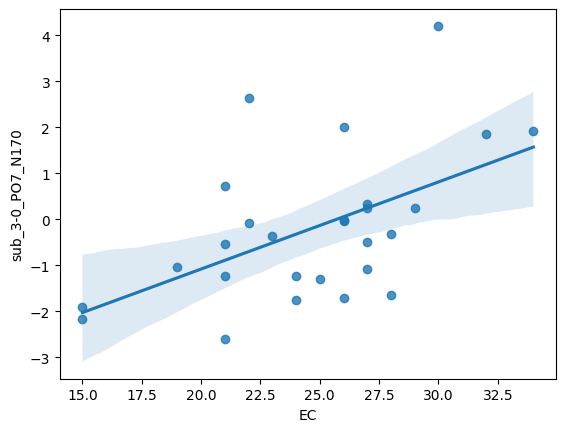

In [15]:
from scipy.stats.stats import pearsonr
import seaborn as sns

x = smile_df_wq["EC"].to_list()
y = smile_df_wq["sub_3-0_PO7_N170"].to_list()

r, p = pearsonr(x,y)

sns.regplot(x="EC", y="sub_3-0_PO7_N170", data=smile_df_wq)
print("r: " + str(r))
print("p: " + str(p))

r: 0.508827373421645
p: 0.0067207731018254545


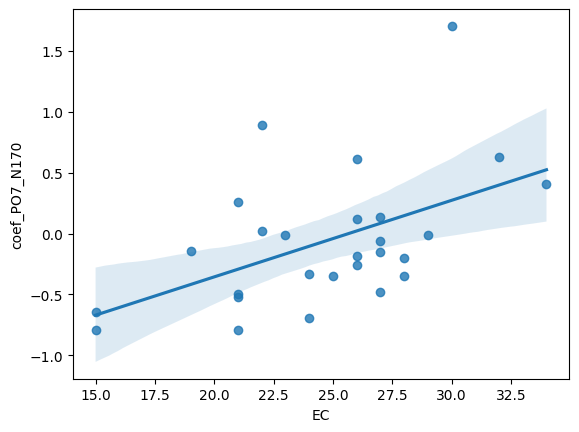

In [16]:
x = smile_df_wq["EC"].to_list()
y = smile_df_wq["coef_PO7_N170"].to_list()

r, p = pearsonr(x,y)

sns.regplot(x="EC", y="coef_PO7_N170", data=smile_df_wq)
print("r: " + str(r))
print("p: " + str(p))

#Fearful faces data

まとめて

In [64]:
def scat_plots(df, ylist):

  for y in ylist:
    sns.scatterplot(x='EC', y=y, data=df)
    plt.title(f'Scatter plot between EC and {y}')
    plt.show()

    # 相関係数とp値の計算
    pearson_corr, p_value = pearsonr(df['EC'], df[y])
    print(f"Pearson's correlation coefficient between EC and {y}: {pearson_corr}")
    print(f"P-value: {p_value}")
    print("\n")

In [ ]:

def coef_scatter(title, df_results):
  fig, ax1 = plt.subplots(1,1, figsize = (3, 3))

  slope, intercept, r_value, p_value, std_err = linregress(df_results["EC"], df_results["coef"])

  ax1.scatter(df_results["EC"], df_results["coef"])
  ax1.set_xlabel("EC")
  ax1.set_ylabel("Coefficient")
  ax1.set_title(title, weight = "bold")
  ax1.spines["top"].set_visible(False)
  ax1.spines["right"].set_visible(False)

  ax1.set_xticks(np.arange(15, 40, 5))
  ax1.set_xlim(13, 35)

  trendline = slope * df_results["EC"] + intercept
  ax1.plot(df_results["EC"], trendline, color='black', label="Trendline")

  df_results.to_csv(title + ".csv")
  plt.savefig(title + ".png", dpi = 500, bbox_inches='tight')